<a href="https://colab.research.google.com/github/zhukuixi/d2l/blob/main/Kaggle_House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
!pip uninstall matplotlib
!pip install matplotlib==3.0.0
!pip install matplotlib_inline

import torch
from torch import nn
import numpy as np
from d2l import torch as d2l
from torch.utils import data


In [162]:
import hashlib
import os
import tarfile
import zipfile
import requests


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')): 
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None): 
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [163]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = ( 
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = ( 
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [164]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [165]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [166]:
#去除第一列ID列并合并
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# 数据预处理

## numeric feature的缺失值填补和标准化

In [167]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

## categorical feature的编码

In [168]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

## 通过values属性，我们可以从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练。

In [169]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# 训练

In [170]:
in_features = train_features.shape[1]

# model
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

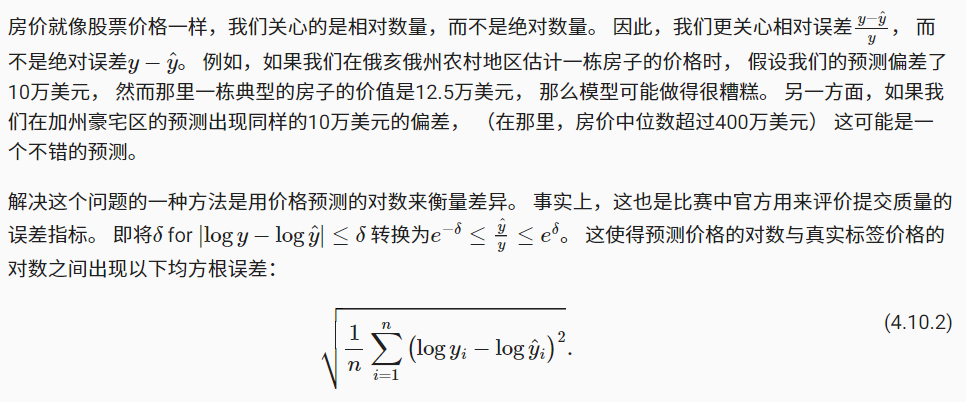

In [171]:
# loss
loss = nn.MSELoss()
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1    
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()



In [172]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):  
        for X, y in train_iter:            
            optimizer.zero_grad()
            l = loss(net(X), y)         
            l.backward()            
            optimizer.step()
            
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证

In [173]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [174]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

# 模型选择

折1，训练log rmse0.170015, 验证log rmse0.156782
折2，训练log rmse0.162266, 验证log rmse0.190157
折3，训练log rmse0.163548, 验证log rmse0.168250
折4，训练log rmse0.167816, 验证log rmse0.154713
折5，训练log rmse0.162855, 验证log rmse0.182642
5-折验证: 平均训练log rmse: 0.165300, 平均验证log rmse: 0.170509


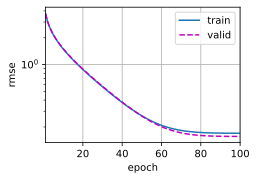

In [175]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

请注意，有时一组超参数的训练误差可能非常低，但折交叉验证的误差要高得多， 这表明模型过拟合了。 在整个训练过程中，你将希望监控训练误差和验证误差这两个数字。 较少的过拟合可能表明现有数据可以支撑一个更强大的模型， 较大的过拟合可能意味着我们可以通过正则化技术来获益。

# 完成Kaggle预测
- 既然我们知道应该选择什么样的超参数， 我们不妨使用所有数据对其进行训练 （而不是仅使用交叉验证中使用的的数据）。 然后，我们通过这种方式获得的模型可以应用于测试集。 将预测保存在CSV文件中可以简化将结果上传到Kaggle的过程。

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。    
    preds = net(test_features).detach().numpy()  
    preds = np.exp(preds)
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162603


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


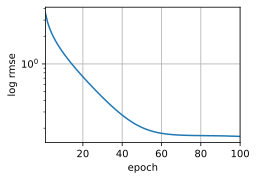

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

#迭代改进！

### 改动1:让loss更加贴近比赛规定的metric：RMSLE.

做法是将label y做log(y)，在此基础上训练模型，同时做预测的时候需要exp(y)。

Reference: 参照kaggle book的P112，用MSE的loss来实现RMSLE的效果！因为比赛时RMSLE作为最终metric的





In [176]:
train_labels_log = torch.log(train_labels)

折1，训练log rmse1.098848, 验证log rmse1.072660
折2，训练log rmse0.889292, 验证log rmse0.830469
折3，训练log rmse1.711663, 验证log rmse1.667954
折4，训练log rmse2.191012, 验证log rmse2.141333
折5，训练log rmse1.517290, 验证log rmse1.544436
5-折验证: 平均训练log rmse: 1.481621, 平均验证log rmse: 1.451370


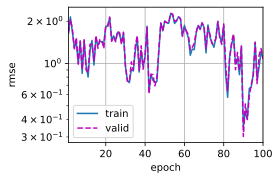

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels_log, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

<font color='cyan'>观察发现RMSLE在train和test中都变大了（从0.16增大到1.48)，而且在第一个fold的图像波动非常的大。由此决定调整学习率，怀疑是学习率太大导致波动剧烈，于是我们尝试缩小learning rate</font>





折1，训练log rmse0.176358, 验证log rmse0.180590
折2，训练log rmse0.864568, 验证log rmse0.929687
折3，训练log rmse0.343362, 验证log rmse0.314498
折4，训练log rmse1.013412, 验证log rmse0.989773
折5，训练log rmse0.046779, 验证log rmse0.049245
5-折验证: 平均训练log rmse: 0.488896, 平均验证log rmse: 0.492759


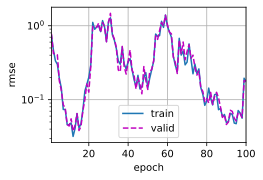

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 1, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels_log, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')




折1，训练log rmse0.013974, 验证log rmse0.018887
折2，训练log rmse0.020912, 验证log rmse0.033045
折3，训练log rmse0.028406, 验证log rmse0.027485
折4，训练log rmse0.010571, 验证log rmse0.011896
折5，训练log rmse0.028200, 验证log rmse0.042492
5-折验证: 平均训练log rmse: 0.020413, 平均验证log rmse: 0.026761


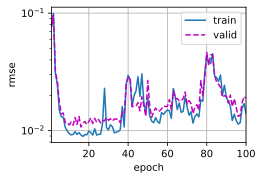

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.05, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels_log, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.008072, 验证log rmse0.011322
折2，训练log rmse0.007481, 验证log rmse0.014142
折3，训练log rmse0.007556, 验证log rmse0.013305
折4，训练log rmse0.008668, 验证log rmse0.010723
折5，训练log rmse0.008197, 验证log rmse0.015259
5-折验证: 平均训练log rmse: 0.007995, 平均验证log rmse: 0.012950


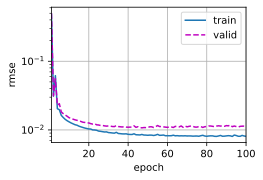

In [178]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels_log, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

original log rmse vali = 0.16   
learning rate = [5,1,0.05,0.01]  
log rmse vali = [1.45,0.49,0.02,0.01]  
发现在lr=0.01时符合理想的趋近图像！
通过log(y)的变化和learning rate的调整我们完成了version1!
发现我们在kaggle的loss分数从0.16~提升到0.15~


训练log rmse：0.008154


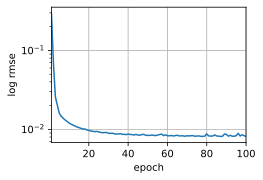

In [179]:
def train_and_pred_temp(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size,outputFileName):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。    
    preds = net(test_features).detach().numpy()  
    # 加入这一行是为了train_labels_log的实现
    preds = np.exp(preds) 
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv(outputFileName, index=False)

train_and_pred_temp(train_features, test_features, train_labels_log, test_data,
               num_epochs, lr, weight_decay, batch_size,'v1.csv')

## 改动2：来尝试更加深的网络

In [188]:
# model
dropout1,dropout2 = 0.2,0.5

def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 128),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(128, 64),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(64, 1))
    return net
    
      
                       

折1，训练log rmse0.099636, 验证log rmse0.098323
折2，训练log rmse0.087174, 验证log rmse0.092187
折3，训练log rmse0.091055, 验证log rmse0.090189
折4，训练log rmse0.090545, 验证log rmse0.093084
折5，训练log rmse0.091966, 验证log rmse0.095007
5-折验证: 平均训练log rmse: 0.092075, 平均验证log rmse: 0.093758


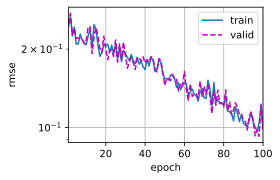

In [189]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels_log, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

<font color='cyan'>很显然现在epoch数目还不够，于是从100epoch增加到500,为了看得清楚，修改了一下k_fold里的画图函数

In [200]:
def k_fold_temp(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size,starting_step):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(starting_step, num_epochs)), [train_ls[starting_step:], valid_ls[starting_step:]],
                     xlabel='epoch', ylabel='rmse', xlim=[starting_step, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.013866, 验证log rmse0.017256
折2，训练log rmse0.012225, 验证log rmse0.015026
2-折验证: 平均训练log rmse: 0.013046, 平均验证log rmse: 0.016141


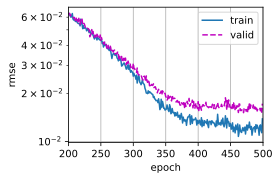

In [201]:
k, num_epochs, lr, weight_decay, batch_size = 2, 500, 0.01, 0, 64
train_l, valid_l = k_fold_temp(k, train_features, train_labels_log, num_epochs, lr,
                          weight_decay, batch_size,200)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.015069, 验证log rmse0.018808
折2，训练log rmse0.012796, 验证log rmse0.016630
2-折验证: 平均训练log rmse: 0.013932, 平均验证log rmse: 0.017719


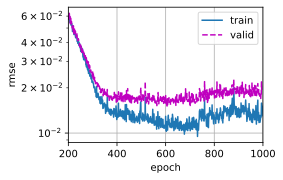

In [210]:
k, num_epochs, lr, weight_decay, batch_size = 2, 1000, 0.01, 0, 64
train_l, valid_l = k_fold_temp(k, train_features, train_labels_log, num_epochs, lr,
                          weight_decay, batch_size,200)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

训练log rmse：0.013912


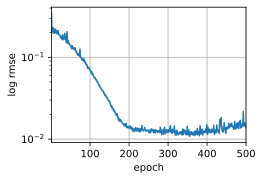

In [209]:
def train_and_pred_temp(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size,outputFileName):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。    
    preds = net(test_features).detach().numpy()  
    # 加入这一行是为了train_labels_log的实现
    preds = np.exp(preds) 
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv(outputFileName, index=False)

train_and_pred_temp(train_features, test_features, train_labels_log, test_data,
               num_epochs, lr, weight_decay, batch_size,'v2.csv')

<font color="cyan">然而递交到kaggle后结果并不好！loss变成0.20~